In [1]:
import numpy as np
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
from datetime import datetime

##Importação dos dados de demanda

In [2]:
data_hourly = read_csv('Dados_JPS_12B1.csv',sep=';',decimal=',')
data_hourly.dropna(axis=1,inplace=True) # Eliminar os dados NaN
data_hourly.rename(columns={'JPS_12B1':'POTENCIA'},inplace=True) #Renomear a coluna dos dados de Potência
data_hourly.head(10)

,DIA,MES,ANO,HORA,MINUTO,POTENCIA
0,1,1,2008,0,0,7.9
1,1,1,2008,0,15,7.7
2,1,1,2008,0,30,7.7
3,1,1,2008,0,45,7.4
4,1,1,2008,1,0,7.4
5,1,1,2008,1,15,7.4
6,1,1,2008,1,30,7.4
7,1,1,2008,1,45,7.2
8,1,1,2008,2,0,7.2
9,1,1,2008,2,15,7.3


In [3]:
#Converter as colunas de tempo para o formato datetime
data_hourly['TEMPO'] = data_hourly[['DIA','MES','ANO','HORA','MINUTO']].apply(lambda x : datetime(year=x[2],month=x[1],day=x[0],hour=x[3],minute=x[4]), axis=1)
data_hourly['TEMPO']
data_hourly.drop(['DIA','MES','ANO','HORA','MINUTO'],axis=1,inplace=True)

data_hourly.set_index('TEMPO',inplace=True) #Configurar as datas como index

#Converter para float
data_hourly['POTENCIA'] = data_hourly['POTENCIA'].astype(float)
data_hourly

,POTENCIA
TEMPO,
2008-01-01 00:00:00,7.9
2008-01-01 00:15:00,7.7
2008-01-01 00:30:00,7.7
2008-01-01 00:45:00,7.4
2008-01-01 01:00:00,7.4
...,...
2013-12-31 22:45:00,9.6
2013-12-31 23:00:00,9.6
2013-12-31 23:15:00,9.3


In [4]:
#maxima_semanal = data_hourly.groupby(pd.Grouper(freq='W')).max()
#maxima_diaria = data_hourly.groupby(pd.Grouper(freq='D')).max()

#Como as datas que são agrupadas são índices do DataFrame, utiliza-se o resample

maxima_semanal=data_hourly.resample('W').max()
maxima_diaria =data_hourly.resample('D').max()


In [5]:
maxima_diaria

,POTENCIA
TEMPO,
2008-01-01,9.000000
2008-01-02,13.200000
2008-01-03,13.900000
2008-01-04,13.000000
2008-01-05,9.800000
...,...
2013-12-27,17.400000
2013-12-28,12.000000
2013-12-29,11.300000


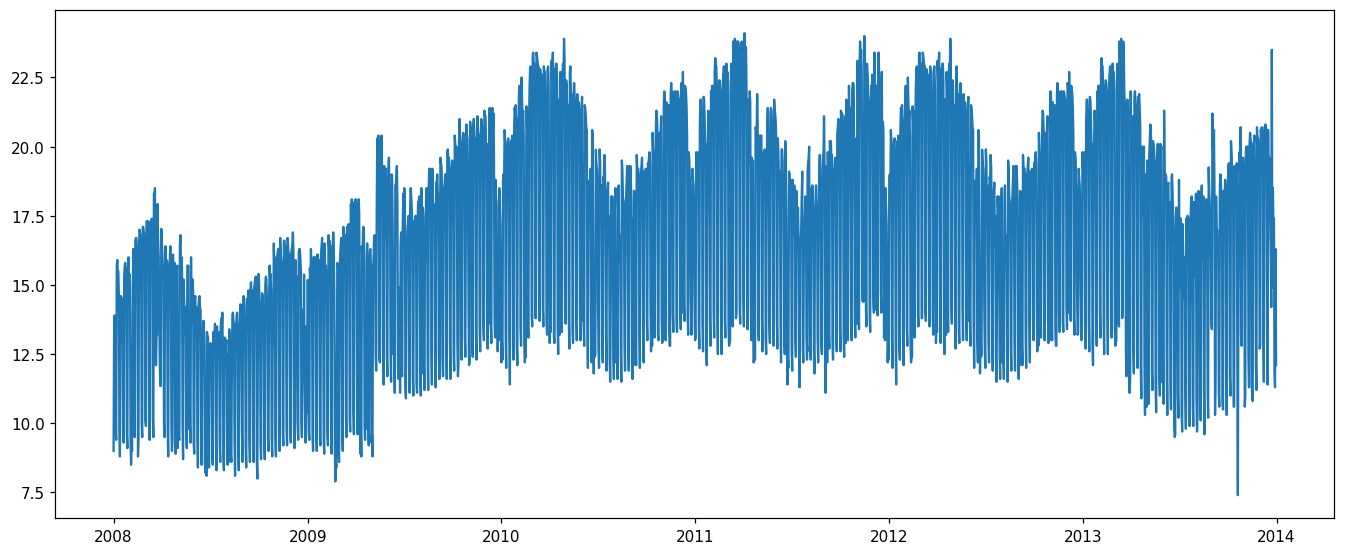

In [6]:
plt.figure(figsize=(15,6),dpi=110)
plt.plot(maxima_diaria)
plt.show()

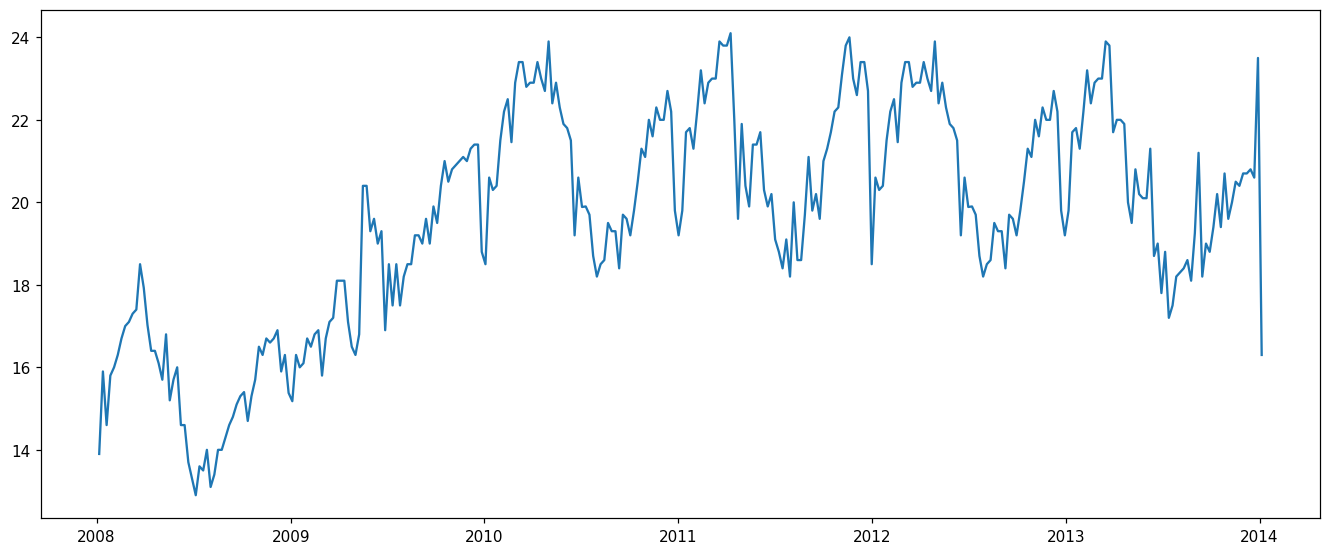

In [7]:
plt.figure(figsize=(15,6),dpi=110)
plt.plot(maxima_semanal)
plt.show()

##Tratamento dos dados

,POTENCIA
TEMPO,
2008-04-13,16.523719
2008-04-20,16.690386
2008-04-27,16.703719
2008-05-04,16.777053
2008-05-11,16.843719
...,...
2013-12-08,19.870000
2013-12-15,19.973333
2013-12-22,19.933333


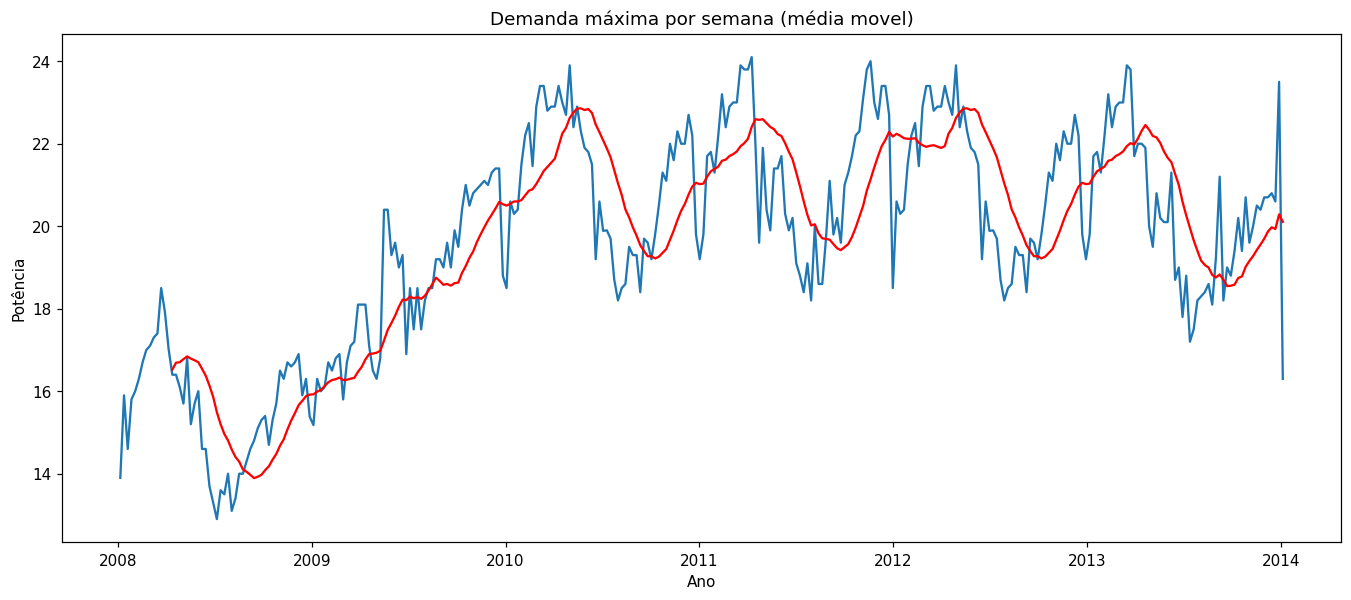

In [8]:
#Média Móvel
maxima_semanal_mm = maxima_semanal['POTENCIA'].rolling(15).mean().dropna()

plt.figure(figsize=(15,6),dpi=110)
plt.plot(maxima_semanal)
plt.plot(maxima_semanal_mm,'r')
plt.title('Demanda máxima por semana (média movel)')
plt.ylabel('Potência')
plt.xlabel('Ano')

pd.DataFrame(maxima_semanal_mm)

,POTENCIA
TEMPO,
2008-01-15,12.826667
2008-01-16,13.173333
2008-01-17,13.260000
2008-01-18,13.273333
2008-01-19,13.046667
...,...
2013-12-27,17.441419
2013-12-28,16.888086
2013-12-29,16.761419


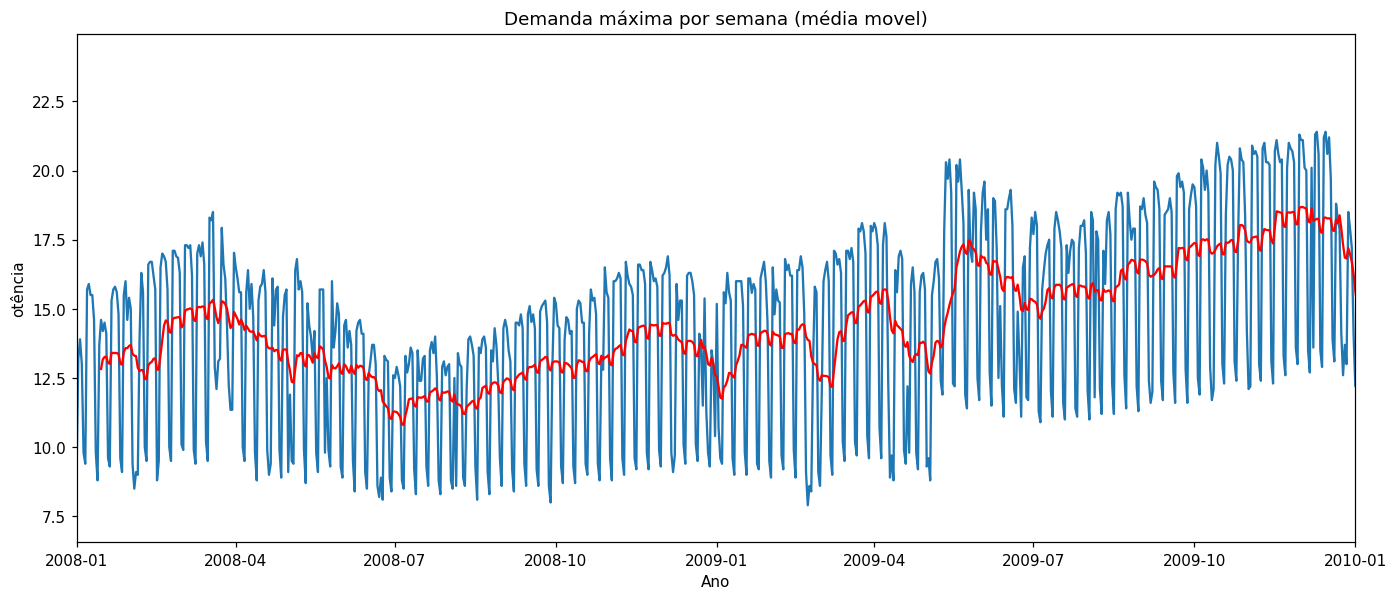

In [9]:
maxima_diaria_mm = maxima_diaria['POTENCIA'].rolling(15).mean().dropna()

plt.figure(figsize=(15,6),dpi=110)
plt.plot(maxima_diaria)
plt.plot(maxima_diaria_mm,'r')
plt.title('Demanda máxima por semana (média movel)')
plt.ylabel('otência')
plt.xlabel('Ano')

plt.xlim([datetime(2008, 1, 1), datetime(2010, 1, 1)])


pd.DataFrame(maxima_diaria_mm)

##Formação do Banco de Dados

In [10]:
def data_proc(data,n_data_tested,n_data_predict):

    # data -> entrada do conjunto de dados
    # n_data_tested -> número de amostras (histórico) utilizados para predição
    # n_data_predict -> número de amostras a serem preditas
    
    size_window = n_data_tested + n_data_predict

#new_data = np.concatenate(new_data)
    inputs = np.zeros([len(data)-size_window,n_data_tested])
    outputs = np.zeros([len(data)-size_window,n_data_predict])

    for i in range(len(data)-size_window):
        inputs[i] = data[i:(i+n_data_tested)] 
        outputs[i] = data[(i+n_data_tested):(i+size_window)]
        
    return[inputs, outputs]


In [11]:
#data = maxima_semanal_mm
data = maxima_diaria_mm

n_data_tested = 4
n_data_predict = 3 #n_data_predict = (n+1) **O primeiro elemento corresponde ao elemento k**
size_window = n_data_tested + n_data_predict

#new_data = np.concatenate(new_data)
inputs = np.zeros([len(data)-size_window,n_data_tested])
outputs = np.zeros([len(data)-size_window,n_data_predict])

for i in range(len(data)-size_window):
    inputs[i] = data[i:(i+n_data_tested)] 
    outputs[i] = data[(i+n_data_tested):(i+size_window)]

In [12]:
inputsdata_hourly = pd.DataFrame(inputs,columns = ['POTENCIA(k-4)','POTENCIA(k-3)','POTENCIA(k-2)','POTENCIA(k-1)'])
inputsdata_hourly

,POTENCIA(k-4),POTENCIA(k-3),POTENCIA(k-2),POTENCIA(k-1)
0,12.826667,13.173333,13.260000,13.273333
1,13.173333,13.260000,13.273333,13.046667
2,13.260000,13.273333,13.046667,13.013333
3,13.273333,13.046667,13.013333,13.406667
4,13.046667,13.013333,13.406667,13.406667
...,...,...,...,...
2166,17.853840,17.547174,17.633840,18.433840
2167,17.547174,17.633840,18.433840,18.047174
2168,17.633840,18.433840,18.047174,17.901419
2169,18.433840,18.047174,17.901419,17.661419


In [13]:
outputsdata_hourly = pd.DataFrame(outputs,columns = ['POTENCIA(k)','POTENCIA(k+1)','POTENCIA(k+2)'])
valores_preditos = outputsdata_hourly[['POTENCIA(k+1)','POTENCIA(k+2)']]
outputsdata_hourly
#valores_preditos

,POTENCIA(k),POTENCIA(k+1),POTENCIA(k+2)
0,13.046667,13.013333,13.406667
1,13.013333,13.406667,13.406667
2,13.406667,13.406667,13.400000
3,13.406667,13.400000,13.406667
4,13.400000,13.406667,13.360000
...,...,...,...
2166,18.047174,17.901419,17.661419
2167,17.901419,17.661419,17.441419
2168,17.661419,17.441419,16.888086
2169,17.441419,16.888086,16.761419


###Verificação dos dados

In [14]:
BD = pd.concat([inputsdata_hourly, outputsdata_hourly],axis=1)
BD.head(20)
cols = BD.columns.tolist()
cols = ['POTENCIA(k)','POTENCIA(k-1)','POTENCIA(k-2)','POTENCIA(k-3)','POTENCIA(k-4)','POTENCIA(k+1)','POTENCIA(k+2)']
#cols[0] = cols[4]
#cols.pop(4)
BD = BD[cols]
BD.dropna(axis=0)
BD

,POTENCIA(k),POTENCIA(k-1),POTENCIA(k-2),POTENCIA(k-3),POTENCIA(k-4),POTENCIA(k+1),POTENCIA(k+2)
0,13.046667,13.273333,13.260000,13.173333,12.826667,13.013333,13.406667
1,13.013333,13.046667,13.273333,13.260000,13.173333,13.406667,13.406667
2,13.406667,13.013333,13.046667,13.273333,13.260000,13.406667,13.400000
3,13.406667,13.406667,13.013333,13.046667,13.273333,13.400000,13.406667
4,13.400000,13.406667,13.406667,13.013333,13.046667,13.406667,13.360000
...,...,...,...,...,...,...,...
2166,18.047174,18.433840,17.633840,17.547174,17.853840,17.901419,17.661419
2167,17.901419,18.047174,18.433840,17.633840,17.547174,17.661419,17.441419
2168,17.661419,17.901419,18.047174,18.433840,17.633840,17.441419,16.888086
2169,17.441419,17.661419,17.901419,18.047174,18.433840,16.888086,16.761419


In [15]:
BD = pd.concat([inputsdata_hourly, outputsdata_hourly],axis=1)
BD

,POTENCIA(k-4),POTENCIA(k-3),POTENCIA(k-2),POTENCIA(k-1),POTENCIA(k),POTENCIA(k+1),POTENCIA(k+2)
0,12.826667,13.173333,13.260000,13.273333,13.046667,13.013333,13.406667
1,13.173333,13.260000,13.273333,13.046667,13.013333,13.406667,13.406667
2,13.260000,13.273333,13.046667,13.013333,13.406667,13.406667,13.400000
3,13.273333,13.046667,13.013333,13.406667,13.406667,13.400000,13.406667
4,13.046667,13.013333,13.406667,13.406667,13.400000,13.406667,13.360000
...,...,...,...,...,...,...,...
2166,17.853840,17.547174,17.633840,18.433840,18.047174,17.901419,17.661419
2167,17.547174,17.633840,18.433840,18.047174,17.901419,17.661419,17.441419
2168,17.633840,18.433840,18.047174,17.901419,17.661419,17.441419,16.888086
2169,18.433840,18.047174,17.901419,17.661419,17.441419,16.888086,16.761419


##Separação dos conjuntos de Treino e Teste

In [27]:
#implementação da RNA
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
#n_data_tested = 10
#n_data_predict = 2

#data_train = data[0:int(0.7*len(data))]
#data_test = data[:int(0.3*len(data))] #30% dos dados utilizados para teste
 
#[inputs_train, outputs_train] = data_proc(data_train,n_data_tested,n_data_predict)
#[inputs_test, outputs_test] = data_proc(data_test,n_data_tested,n_data_predict)

In [ ]:
data = np.array(BD)
data_norm = tf.keras.utils.normalize(data,axis=1)

input_train = data_norm[0:int(0.7*len(inputs)),0:5]
input_test = data_norm[int(0.7*len(inputs)):-1,0:5] 

output_train = data_norm[0:int(0.7*len(outputs)),5:7]
output_test = data_norm[int(0.7*len(outputs)):-1,5:7] 

In [ ]:
entrada_train = tf.convert_to_tensor(input_train)
saida_train = tf.convert_to_tensor(output_train)
entrada_test = tf.convert_to_tensor(input_test)
saida_test = tf.convert_to_tensor(output_test)

###Testes com o train_test_split da biblioteca sci-kit learn

In [ ]:
#X = np.array(inputsdata_hourly)
#y = np.array(outputsdata_hourly)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#X_train = np.concatenate(X_train)
#y_train = np.concatenate(y_train)
#X_test = np.concatenate(X_test)
#y_test = np.concatenate(y_test)

In [ ]:
#data_hourly_teste = pd.DataFrame(X_test)
#plt.figure(figsize=(30,16),dpi=110)

#fig, ax = plt.subplots(1, 1,figsize=(15,6))
#data_daily=pd.DataFrame(maxima_semanal['POTENCIA'])
#data_daily.reset_index(inplace=True)
#data_daily.drop(['TEMPO'],axis=1,inplace=True)
#data_daily.plot(ax=ax)
#data_hourly_teste.plot(ax=ax)
#plt.show()
#data_hourly_teste
#data_daily

##Montagem da Rede Neural Artificial

In [ ]:

model = keras.Sequential([
    keras.Input(5),#shape=(entrada_train.shape[1],)),  # input layer (1)
    keras.layers.Dense(50, activation='sigmoid'),  # hidden layer (1)
    keras.layers.Dense(50, activation='sigmoid'),  # hidden layer (2)
    keras.layers.Dense(2, activation='sigmoid') # output layer 
])


opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer = opt,
              loss='mse',
              metrics=['accuracy'])

model.summary()

model.fit(entrada_train, saida_train, shuffle=True, epochs=5000)

A saída de streaming foi truncada nas últimas 5000 linhas.
48/48 [==============================] - 0s 3ms/step - loss: 6.2527e-06 - accuracy: 0.7472
Epoch 2502/5000
48/48 [==============================] - 0s 3ms/step - loss: 7.2849e-06 - accuracy: 0.7452
Epoch 2503/5000
48/48 [==============================] - 0s 3ms/step - loss: 6.2789e-06 - accuracy: 0.7558
Epoch 2504/5000
48/48 [==============================] - 0s 3ms/step - loss: 6.4844e-06 - accuracy: 0.7433
Epoch 2505/5000
48/48 [==============================] - 0s 3ms/step - loss: 7.1379e-06 - accuracy: 0.7518
Epoch 2506/5000
48/48 [==============================] - 0s 3ms/step - loss: 6.8527e-06 - accuracy: 0.7459
Epoch 2507/5000
48/48 [==============================] - 0s 3ms/step - loss: 7.0570e-06 - accuracy: 0.7400
Epoch 2508/5000
48/48 [==============================] - 0s 3ms/step - loss: 7.2252e-06 - accuracy: 0.7294
Epoch 2509/5000
48/48 [==============================] - 0s 3ms/step - loss: 7.0540e-06 - accuracy: 0

##Avaliação dos Resultados

In [ ]:
test_loss, test_acc = model.evaluate(entrada_test, saida_test, verbose=1) 

print('Test accuracy:', test_acc)

21/21 [==============================] - 0s 1ms/step - loss: 6.6339e-06 - accuracy: 0.7189
Test accuracy: 0.7188940048217773


In [ ]:
predictions = model.predict(entrada_test)

plt.figure(figsize=(15,6),dpi=110)
plt.plot(predictions[:,0],'r')
plt.plot(saida_test[:,0],'b')
#plt.xlim([0,300])
plt.legend(['Dado Estimado','Dado Real'])
plt.show() 

In [ ]:
import seaborn as sns

plt.figure(figsize=(6,6),dpi=110)
plt.grid(True)
#plt.plot(predictions[:,0]-saida_test[:,0])
#plt.xlim([0,91])
sns.distplot(predictions[:,0]-saida_test[:,0])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


In [ ]:
plt.figure(figsize=(6,6),dpi=110)
sns.histplot(predictions[:,0]*BD['POTENCIA(k+1)'].max())